In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint

### Opening predator-prey dataset

In [2]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


[ 0.          0.2020202   0.4040404   0.60606061  0.80808081  1.01010101
  1.21212121  1.41414141  1.61616162  1.81818182  2.02020202  2.22222222
  2.42424242  2.62626263  2.82828283  3.03030303  3.23232323  3.43434343
  3.63636364  3.83838384  4.04040404  4.24242424  4.44444444  4.64646465
  4.84848485  5.05050505  5.25252525  5.45454545  5.65656566  5.85858586
  6.06060606  6.26262626  6.46464646  6.66666667  6.86868687  7.07070707
  7.27272727  7.47474747  7.67676768  7.87878788  8.08080808  8.28282828
  8.48484848  8.68686869  8.88888889  9.09090909  9.29292929  9.49494949
  9.6969697   9.8989899  10.1010101  10.3030303  10.50505051 10.70707071
 10.90909091 11.11111111 11.31313131 11.51515152 11.71717172 11.91919192
 12.12121212 12.32323232 12.52525253 12.72727273 12.92929293 13.13131313
 13.33333333 13.53535354 13.73737374 13.93939394 14.14141414 14.34343434
 14.54545455 14.74747475 14.94949495 15.15151515 15.35353535 15.55555556
 15.75757576 15.95959596 16.16161616 16.36363636 16

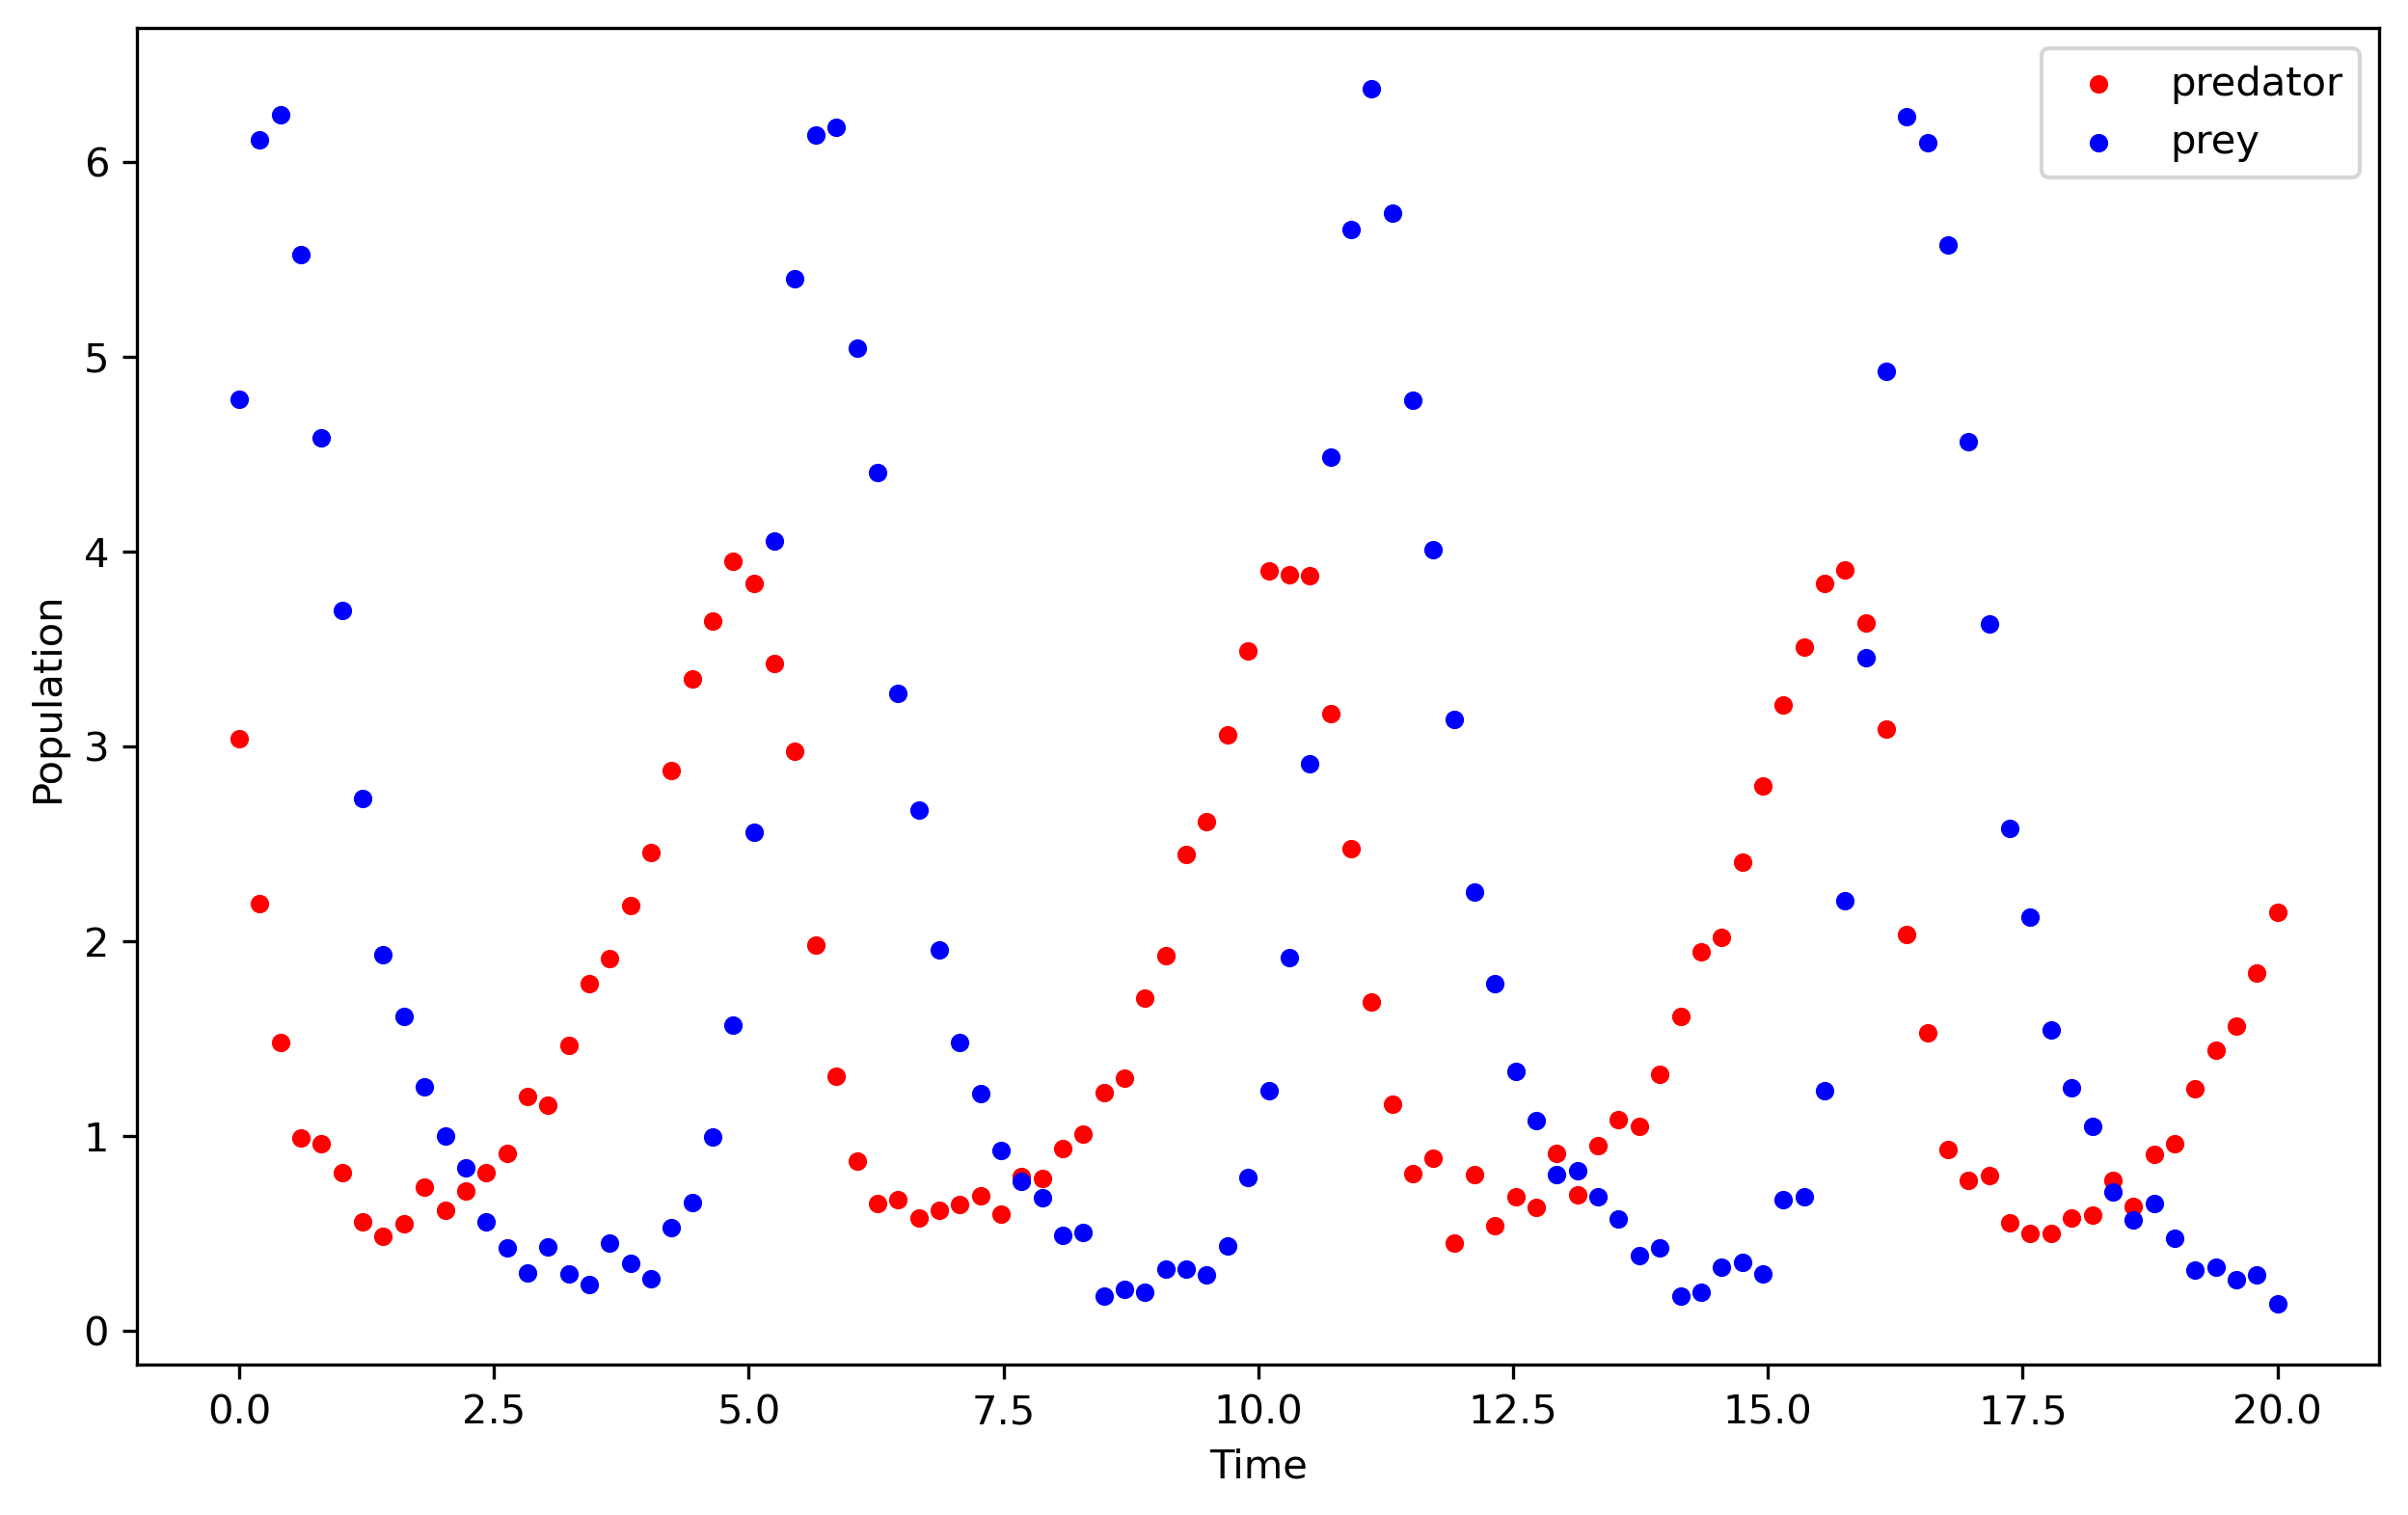

In [15]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values.T
data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False
# print(data)

# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
plt.scatter(data[0], data[1], label = 'predator', color = 'red', s =point_width)
plt.scatter(data[0], data[2], label = 'prey', color = 'blue', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()

print(data[0])

### Objective functions

#### Defining volterra equations function

In [4]:
def lotka_volterra(time, initial, alpha, beta, delta, gamma):
    #predator = x, prey = y
    x, y = initial
    xs = [x]
    ys = [y]
    for t in time:
        dxdt = (alpha*x) - (beta*x*y)
        dydt = (delta*x*y) - (gamma*y)
        x += dxdt
        y += dydt
        xs.append(x)
        ys.append(y)
    return xs, ys

In [5]:
def predator_prey_odes(initial_conditions,alpha, beta, delta, gamma):

    x = initial_conditions[0] #initial predator population
    y = initial_conditions[1] #initial prey population

    dxdt = (alpha*x) - (beta*x*y) #Predator ODE
    dydt = (delta*x*y) - (gamma*x*y) #Predator ODE

    return [dxdt,dydt]




In [6]:
#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_function(time,initial_conditions,alpha,beta,delta,gamma): 
    
    #odeint is now used as part of this function which returns the # of infected in the model
    predator_values, prey_values = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    
    return [predator_values,prey_values]

#Prey objective function



### Defining objective functions

In [7]:
def negative_log_likelihood(actual, predicted, variance=1.0):
    '''Log likelyhood function'''
    # Assuming a normal distribution for simplicity
    log_likelihoods1 =norm.logpdf(actual[0], loc=predicted[0], scale=np.sqrt(variance))
    log_likelihoods2 = norm.logpdf(actual[1], loc=predicted[1], scale=np.sqrt(variance))
                                  
    return -np.sum((log_likelihoods1,log_likelihoods2))

def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

### Algorithms & Optimisation

In [11]:
def hill_climbing(initial, parameters, objective, max_iterations = 100, variance=1):
    '''Tries to find the best solution using random walker'''
    iteration = 0
    alpha_0, beta_0, delta_0, gamma_0 = parameters
    for _ in range(max_iterations):
        alpha_2 , beta_0, delta_0, gamma_0 = np.random.multivariate_normal
        
def simulated_annealing(search_space,function,temp):

    scale = np.sqrt(temp) #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases

    start = np.random.choice(search_space) #Start with a random x value 

    x = start * 1

    cur = function(x) #The function value of the current x solution

    history = [x] #Stores previously searched x values

    for i in range (1000):

        proposal = x + np.random.normal() * scale #A new solutiom is generated by adding a normally distributed random value to the current solution x

        delta = function(proposal) - cur


        if proposal < 0 or proposal > 1:
           proposal = x # Reject proposal if it is not in the correct range
    
        elif delta < 0:
            x = proposal ##Accept proposal

        elif np.exp(delta/temp) < np.random.rand(): #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x = proposal #Accept proposal

        
        cur = function(x)
        temp = 0.9 * temp #Cool temperature
        history.append(temp) #Add to history
    
    return x, history
        
        